This notebook explains how to calculate biases to galaxy clustering auto-spectra, using parallelization in NERSC 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import biases

%matplotlib inline
%load_ext autoreload
%autoreload 2

/tmp/ipykernel_83628/1461854785.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


#### Setup

Define the scenario we want to consider

In [2]:
sigma = 0.06 # Standard deviation of the fiducial dndz
z_mean = 0.59 # Central redshift of the fiducial dndz

# Set the range for the integrals over r. If this changes, the normalization of phi(r) will need to be changed too
z_min_int = 0.005
z_max_int = z_mean+2

# Now characterize the perturbations to the dndz
error_on_meanz = 0.017*(1+z_mean) # Error on RedMaGiC mean z, from arXiv:1708.01536
sigma_zshift = error_on_meanz # Standard deviation of the shifts in the central redshift of the distribution
sigma_zwidth = 0 #sigma/10. # Standard deviation of the variations in the width of the distribution
modulation_of_mean_of_draws = 0 # Consider also modulating the mean of these shifts across the sky

We also need to define the Lagrangian bias parameters for the galaxy power spectrum (if you want to use a different prescription, it's easy to modify the code to do so)

In [3]:
#UNIT-redmagic bias parameters from 2101.11014
#         b1,    b2,    bs2,   bnabla2, SN
bvec = [0.786, 0.583, -0.406, -0.512, 1755]

#### Preprocessing

First, a bit of pre-processing:

In [ ]:
for nside in np.array([8, 16, 32]):
    for sigma_zshift in np.array([2, 1, 0.5, 0.1])*error_on_meanz:
        temp_exp = biases.experiment(sigma, z_mean, sigma_zshift, sigma_zwidth, nside, bvec)
        filename = '/pscratch/sd/a/ab2368/data/redmagic_wn_NOSMOOTHING_sigmazshift{}_nside{}'.format(sigma_zshift, nside)
        # We save the key properties to file so they can be load by the parallel processes we're about to create
        temp_exp.save_properties(filename)

Note that you can already generate some interesting visualizations. For example:

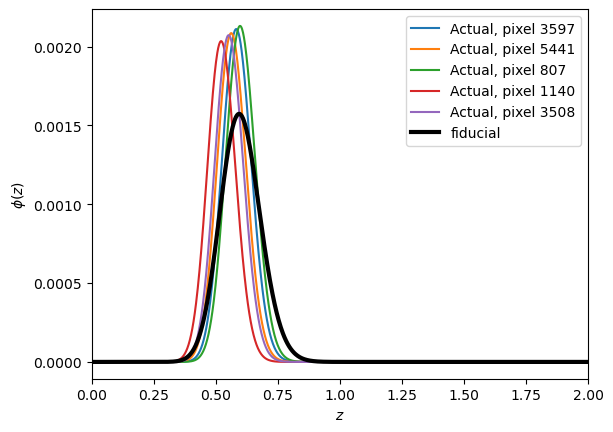

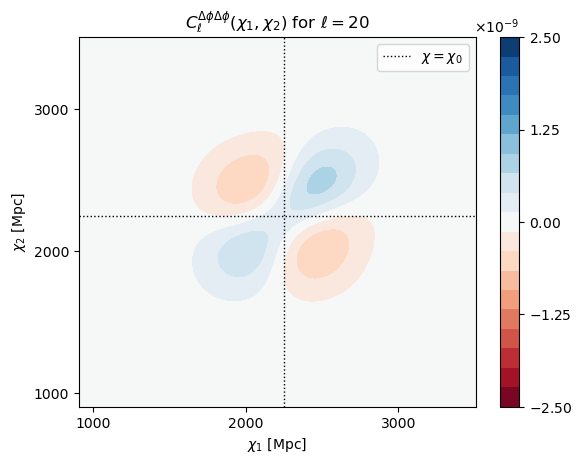

In [422]:
temp_exp.plot_realizations()
plt.show()
temp_exp.plot_ClDphi_vs_chi_chiprime_2D(20)

#### Scripts for parallelization

Let's write a script to compute the biases in parallel, using a different core/process for each $\ell$:

In [24]:
%%writefile /global/u1/a/ab2368/varying_dndzs/Varying_dndzs/scripts/compute_modecoupling_bias_in_parallel.py
#!/global/homes/a/ab2368/.conda/envs/varying_dndz python
import sys
sys.path.insert(0, '/global/homes/a/ab2368/varying_dndzs/Varying_dndzs/biases_code/')
import numpy as np
import biases

# Load scenario from file
sigma_zshifts = np.array([2, 1, 0.5, 0.1])*0.02703
nsides = np.array([8, 16, 32])

# Hyperparameters for numerical integration
num_processes = 1
miniter = 1000
maxiter = 5000
tol = 1e-11
lprime_max = 'none'

# The ells where we want to evaluate the spectra
ells = np.logspace(np.log10(50), np.log10(1500), 48, dtype=int)

count = 0
for sigma_zshift in sigma_zshifts:
    for nside in nsides:
        print('running with nside={}, sigma_zshift={}'.format(nside, sigma_zshift))
        filename = '/pscratch/sd/a/ab2368/data/redmagic_wn_NOSMOOTHING_sigmazshift{}_nside{}'.format(sigma_zshift, nside)
        loaded_exp = biases.load_from_file(filename)
        loaded_exp.ells = ells
        if count==0:
            # In all these cases, the unbiased PS is the same, so we only calculate it once
            unbiased_clgg = biases.unbiased_term(loaded_exp, loaded_exp.ells, num_processes=num_processes, miniter=miniter, maxiter=maxiter, tol=tol)
        loaded_exp.unbiased_clgg = unbiased_clgg
        print('running with lprime_max={}'.format(lprime_max))
        
        # Compute full mode-coupling bias
        loaded_exp.conv_bias = biases.mode_coupling_bias(loaded_exp, loaded_exp.ells, lprime_max=lprime_max, num_processes=num_processes,
                                                         miniter=miniter, maxiter=maxiter, tol=tol)
        # Compute analytic approximations to mode-coupling bias
        loaded_exp.analytic_mcbias_toy_model = biases.mode_coupling_bias(loaded_exp, loaded_exp.ells, num_processes=num_processes, 
                                                                         miniter=miniter, maxiter=maxiter, tol=tol, mode='analytic_toy_model')
        loaded_exp.analytic_mcbias_via_variance = biases.mode_coupling_bias(loaded_exp, loaded_exp.ells, num_processes=num_processes, 
                                                                            miniter=miniter, maxiter=maxiter, tol=tol, mode='analytic_via_variance')

        # Compute additive bias
        loaded_exp.additive_bias = biases.additive_bias(loaded_exp, loaded_exp.ells, num_processes=num_processes, miniter=miniter, maxiter=maxiter, tol=tol)

        # Save to file, this time including the biases as an attribute!
        loaded_exp.save_properties(filename)
        print('done with {}'.format(filename))
        count += 1


Overwriting /global/u1/a/ab2368/varying_dndzs/Varying_dndzs/scripts/compute_modecoupling_bias_in_parallel.py


In [449]:
%%writefile /global/u1/a/ab2368/varying_dndzs/Varying_dndzs/scripts/compute_additive_bias_in_parallel.py
#!/global/homes/a/ab2368/.conda/envs/varying_dndz python
import sys
sys.path.insert(0, '/global/homes/a/ab2368/varying_dndzs/Varying_dndzs/biases_code/')
import numpy as np
import biases

# Load scenario from file
sigma_zshifts = np.array([0.1])*0.02703 #np.array([2, 1, 0.5, 0.1])*0.02703 #np.array([0.02703])
nsides = np.array([32])#np.array([8, 16, 32])

# Hyperparameters for numerical integration
num_processes = 1
miniter = 1000
maxiter = 5000
tol = 1e-11

for sigma_zshift in sigma_zshifts:
    for nside in nsides:
        filename = '/pscratch/sd/a/ab2368/data/redmagic_wn_NOSMOOTHING_sigmazshift{}_nside'.format(sigma_zshift, nside)
        loaded_exp = biases.load_from_file(filename)

        # The ells where we want to evaluate the spectra
        loaded_exp.additive_ells = np.logspace(0, np.log10(200), 16, dtype=int)

        if hasattr(loaded_exp, 'additive_bias'):
            print("It looks like you've already computed the bias for this scenario. Please delete it from file you really want to re-rerun things.")
        else:
            loaded_exp.additive_bias = biases.additive_bias(loaded_exp, additive_ells.ells, num_processes=num_processes, miniter=miniter, maxiter=maxiter, tol=tol)

        # Save to file, this time including the biases as an attribute!
        loaded_exp.save_properties(filename)

Overwriting /global/u1/a/ab2368/varying_dndzs/Varying_dndzs/scripts/compute_additive_bias_in_parallel.py


#### Inspecting the outputs

We can now simply plot the biases we've computed

8 0.05406
16 0.05406
32 0.05406
8 0.02703
16 0.02703
32 0.02703
8 0.013515
16 0.013515
32 0.013515
8 0.002703
16 0.002703
32 0.002703


Text(0, 0.5, '$C_\\ell$')

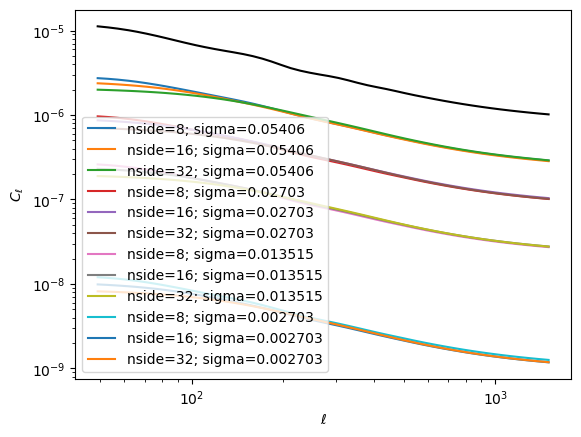

In [23]:
# Load scenario from file
for sigma_zshift in np.array([2, 1, 0.5, 0.1])*error_on_meanz:
    for nside in np.array([8, 16, 32]):
        print(nside, sigma_zshift)
        filename = '/pscratch/sd/a/ab2368/data/redmagic_wn_NOSMOOTHING_sigmazshift{}_nside{}'.format(sigma_zshift, nside)
        loaded_exp = biases.load_from_file(filename)
        plt.loglog(loaded_exp.ells, loaded_exp.conv_bias, label='nside={}; sigma={}'.format(nside, sigma_zshift))

plt.loglog(loaded_exp.ells, loaded_exp.unbiased_clgg, 'k')

plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')

Text(0.5, 1.0, 'These follow roughly the $\\sigma_{\\chi_0}^2$ dependence')

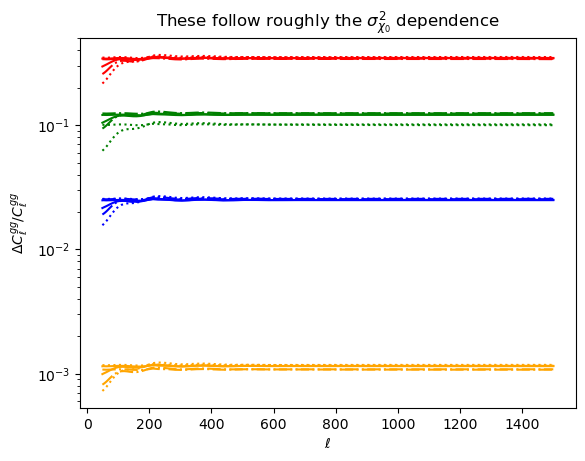

In [25]:
sigma_zshifts = np.array([2, 1, 0.5, 0.1])*error_on_meanz
sigma_zshift_labels = np.array([r'$2\,\sigma_{\chi_0}$', r'$\sigma_{\chi_0}$', r'$\sigma_{\chi_0}/2$', r'$\sigma_{\chi_0}/10$'])
sigma_zshift_colors = np.array(['r', 'g', 'b', 'orange'])
nsides = np.array([8, 16, 32])

for sigma_zshift, color, labels in zip(sigma_zshifts, sigma_zshift_colors, sigma_zshift_labels):
    for nside, ls in zip(nsides, np.array(['-', '-.', ':'])):
        filename = '/pscratch/sd/a/ab2368/data/redmagic_wn_NOSMOOTHING_sigmazshift{}_nside{}'.format(sigma_zshift, nside)
        loaded_exp = biases.load_from_file(filename)
        plt.plot(loaded_exp.ells, loaded_exp.conv_bias/loaded_exp.unbiased_clgg,
                 color=color, ls=ls, label=r'{}'.format(labels))
        
        plt.plot(loaded_exp.ells, loaded_exp.analytic_mcbias_via_variance/loaded_exp.unbiased_clgg, color=color, ls=ls, label=r'analytic_via_variance')

plt.yscale('log')
#plt.legend(ncol=len(sigma_zshifts))
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\Delta C^{gg}_\ell/ C^{gg}_\ell$')
plt.axhline(0, lw=0.5, color='gray')
#plt.xlim([np.min(loaded_exp.ells), np.max(loaded_exp.ells)])
plt.title(r'These follow roughly the $\sigma_{\chi_0}^2$ dependence')

These follow roughly the $\sigma_{\chi_0}^2$ dependence

(-0.05, 0.05)

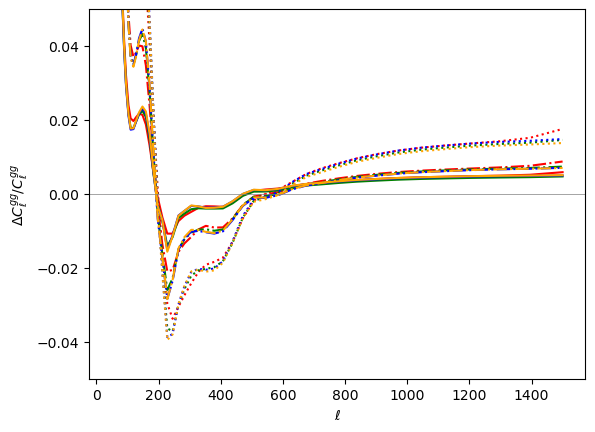

In [29]:
sigma_zshifts = np.array([2, 1, 0.5, 0.1])*error_on_meanz
sigma_zshift_labels = np.array([r'$2\,\sigma_{\chi_0}$', r'$\sigma_{\chi_0}$', r'$\sigma_{\chi_0}/2$', r'$\sigma_{\chi_0}/10$'])
sigma_zshift_colors = np.array(['r', 'g', 'b', 'orange'])
nsides = np.array([8, 16, 32])

for sigma_zshift, color, labels in zip(sigma_zshifts, sigma_zshift_colors, sigma_zshift_labels):
    for nside, ls in zip(nsides, np.array(['-', '-.', ':'])):
        filename = '/pscratch/sd/a/ab2368/data/redmagic_wn_NOSMOOTHING_sigmazshift{}_nside{}'.format(sigma_zshift, nside)
        loaded_exp = biases.load_from_file(filename)
        plt.plot(loaded_exp.ells, (loaded_exp.analytic_mcbias_via_variance-loaded_exp.conv_bias)/loaded_exp.conv_bias,
                 color=color, ls=ls, label=r'{}'.format(labels))
plt.yscale('linear')
#plt.legend(ncol=len(sigma_zshifts))
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\Delta C^{gg}_\ell/ C^{gg}_\ell$')
plt.axhline(0, lw=0.5, color='gray')
#plt.xlim([np.min(loaded_exp.ells), np.max(loaded_exp.ells)])
plt.ylim([-0.05, 0.05])

Note that the approximation is just as good for any $\sigma_{\chi_0}^2$ given some nside. But the agreement worsens for higher nside, presumably because there is higher leakage of power, some of which we lose altogether because it falls above lprime_cut. Presumably, we should see this as well if we compare the variance of the slices as we seed it against the variance we get by summing over $C_l^{\Delta \phi}(\chi)$

Text(0, 0.5, '$\\Delta C^{gg}_\\ell/ C^{gg}_\\ell$')

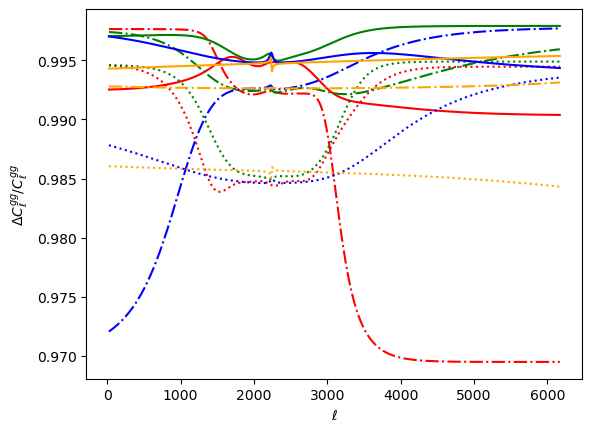

In [38]:
sigma_zshifts = np.array([2, 1, 0.5, 0.1])*error_on_meanz
sigma_zshift_labels = np.array([r'$2\,\sigma_{\chi_0}$', r'$\sigma_{\chi_0}$', r'$\sigma_{\chi_0}/2$', r'$\sigma_{\chi_0}/10$'])
sigma_zshift_colors = np.array(['r', 'g', 'b', 'orange'])
nsides = np.array([8, 16, 32])

for sigma_zshift, color, labels in zip(sigma_zshifts, sigma_zshift_colors, sigma_zshift_labels):
    for nside, ls in zip(nsides, np.array(['-', '-.', ':'])):
        filename = '/pscratch/sd/a/ab2368/data/redmagic_wn_NOSMOOTHING_sigmazshift{}_nside{}'.format(sigma_zshift, nside)
        loaded_exp = biases.load_from_file(filename)
        
        # Measure the variance of each chi-slice directly
        var_direct = loaded_exp.variance_at_distance_slice
        
        # Calculate the variance from the Cl's
        ells = np.arange(loaded_exp.Cl_deltap_of_chi1_chi2.shape[0])
        var_via_cl = np.sum( (2*ells[:,None]+1)*np.diagonal(loaded_exp.Cl_deltap_of_chi1_chi2, axis1=1, axis2=2)/(4*np.pi), axis=0)
        
        plt.plot(loaded_exp.chi_array, var_via_cl/var_direct,
                 color=color, ls=ls, label=r'{}'.format(labels))
plt.yscale('linear')
#plt.legend(ncol=len(sigma_zshifts))
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\Delta C^{gg}_\ell/ C^{gg}_\ell$')
#plt.axhline(0, lw=0.5, color='gray')
#plt.xlim([np.min(loaded_exp.ells), np.max(loaded_exp.ells)])
#plt.ylim([-0.05, 0.05])

Indeed, that's what we're seeing here